### Part 1: Load Playlist Data and Build Co-occurrence Matrix

This section loads the Spotify playlist data from two JSON files and constructs a co-occurrence matrix.
Each node in the matrix represents a track, and edges represent how often two tracks appear together in playlists.
This co-occurrence matrix will be the basis for dimensionality reduction and clustering later on.


In [1]:
import json
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from itertools import combinations
import numpy as np
from sklearn.preprocessing import normalize

# Need to install umap-learn package
import umap

# Load JSON and Build Co-occurrence Matrix

# Load two JSON files that contain Spotify playlist data
with open("data/sample_playlist_data.json", "r") as f:
    data = json.load(f)

#with open("mpd.slice.json", "r") as f:
 #   data2 = json.load(f)

# Merge both JSON data files into one dictionary
#data = {**data1 , **data2}

# Initialize a nested dictionary to store co-occurrence counts between tracks
co_occurrence = defaultdict(Counter)

# Loop through playlists to populate the co-occurrence matrix
for playlist in data:
    # Extract track URIs (last part only) from each playlist
    artists = [track["track_uri"].split(":")[-1] for track in playlist["tracks"]]
    # Remove duplicate tracks in the same playlist
    unique_tracks = list(set(artists))
    # Count co-occurrences between each pair of tracks in the playlist
    for a1, a2 in combinations(unique_tracks, 2):
        co_occurrence[a1][a2] += 1
        co_occurrence[a2][a1] += 1

# Helper to Get Top Co-artists

# This function returns the top_n most co-occurred tracks with a given track
def get_top_coartists(track_uri, co_occurrence, top_n):
    return dict(co_occurrence.get(track_uri, Counter()).most_common(top_n))

# Main Function to Build Cluster Map

# This function constructs a co-occurrence matrix for a given list of seed tracks,
# embeds them into 2D using UMAP, and returns the embedding and metadata
def build_track_cluster_map(seed_track_ids, co_occurrence, top_n):
    # Step 1: Remove duplicates from seed track list
    seed_tracks = list(set(seed_track_ids))
    
    # Step 2: Find all tracks that co-occur with seed tracks
    related_tracks = set(seed_tracks)
    for track in seed_tracks:
        top = co_occurrence.get(track, {})
        most_common = sorted(top.items(), key=lambda x: -x[1])[:top_n]
        related_tracks.update([a for a, _ in most_common])

    related_tracks = list(related_tracks)

    # Step 3: Create index mapping from track URI to matrix index
    track_index = {track: i for i, track in enumerate(related_tracks)}
    # Initialize square matrix for co-occurrence values
    M = np.zeros((len(related_tracks), len(related_tracks)))

    # Populate co-occurrence matrix
    for a1 in related_tracks:
        for a2, count in co_occurrence[a1].items():
            if a2 in track_index:
                i, j = track_index[a1], track_index[a2]
                M[i, j] = count

    # Step 4: Dimensionality reduction using UMAP on the normalized matrix
    reducer = umap.UMAP(n_components=2, random_state=42)
    M_2d = reducer.fit_transform(normalize(M))

    # Return the 2D embedding, list of related tracks, indexing map, and original seeds
    return M_2d, related_tracks, track_index, seed_tracks


### Part 2: Build Lookup Dictionary and Select Sample Tracks

This part defines two helper functions:
1. `build_track_id_lookup`: builds a mapping from (track_name, artist_name) → track URI.
2. `get_track_ids_from_list`: converts a curated list of track/artist names into corresponding track URIs.
It uses multiple fallback strategies to ensure we find the best matching URI even if partial information is missing.

35


/Users/nickgeis/miniconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nickgeis/miniconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


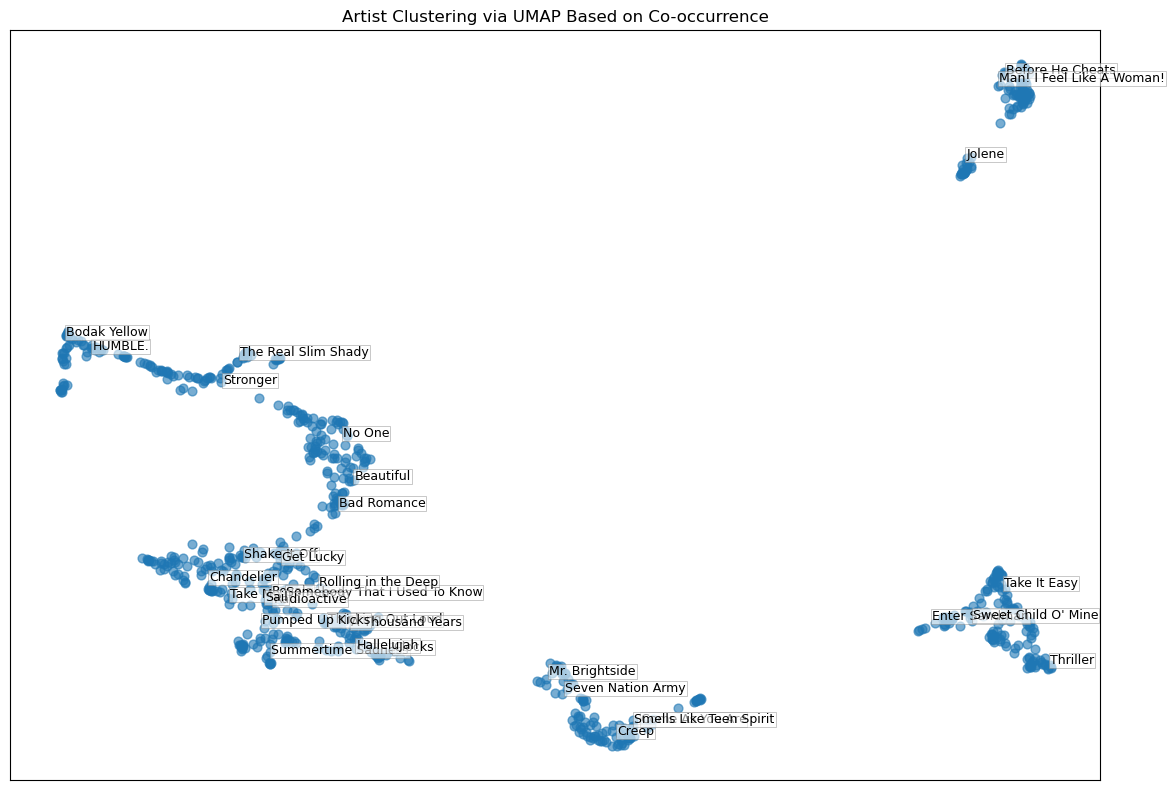

In [2]:
# Example usage with a small sample list

# Build a lookup dictionary from (track_name, artist_name) to track_uri
def build_track_id_lookup(data):
    lookup = {}
    uri_to_name = {}
    for playlist in data:
        for track in playlist["tracks"]:
            artist_name = track["artist_name"].strip()
            track_name = track["track_name"].strip()
            track_uri = track["track_uri"].split(":")[-1]  # Use only the URI string
            key = (track_name.lower(), artist_name.lower())  # Normalize case

            lookup[key] = track_uri  # Add to dictionary for (track, artist) → ID
            uri_to_name[track_uri] = track_name  # Reverse map: ID → track name

    return lookup, uri_to_name

# Given a list of track+artist dictionaries, return a list of matching track URIs
def get_track_ids_from_list(track_artist_list, lookup_dict, fallback_data):
    track_ids = []

    # Build fallback maps using only track or artist name
    fallback_track_map = {}
    fallback_artist_map = {}
    for playlist in fallback_data:
        for track in playlist["tracks"]:
            track_name = track["track_name"].strip().lower()
            artist_name = track["artist_name"].strip().lower()
            track_uri = track["track_uri"].split(":")[-1]

            if track_name not in fallback_track_map:
                fallback_track_map[track_name] = track_uri
            if artist_name not in fallback_artist_map:
                fallback_artist_map[artist_name] = track_uri

    # Resolve each (track, artist) to URI
    for entry in track_artist_list:
        track_name = entry["track_name"].strip().lower()
        artist_name = entry["artist_name"].strip().lower()
        key = (track_name, artist_name)

        # Try full (track + artist) match
        track_id = lookup_dict.get(key)

        # Skip if nothing found
        if track_id:
            track_ids.append(track_id)

    return track_ids


# Build the lookup dictionaries
track_id_lookup, uri_to_name = build_track_id_lookup(data)

# Your list of tracks
sample_song_list = [
    {"track_name": "Smells Like Teen Spirit", "artist_name": "Nirvana"},            
    {"track_name": "Single Ladies", "artist_name": "Beyoncé"},                      
    {"track_name": "Lose Yourself", "artist_name": "Eminem"},                       
    {"track_name": "Hallelujah", "artist_name": "Jeff Buckley"},                    
    {"track_name": "Rolling in the Deep", "artist_name": "Adele"},                  
    {"track_name": "Take Me to Church", "artist_name": "Hozier"},                   
    {"track_name": "Bad Romance", "artist_name": "Lady Gaga"},                      
    {"track_name": "Radioactive", "artist_name": "Imagine Dragons"},                
    {"track_name": "Seven Nation Army", "artist_name": "The White Stripes"},        
    {"track_name": "Gangnam Style", "artist_name": "PSY"},                          
    {"track_name": "Old Town Road", "artist_name": "Lil Nas X"},                    
    {"track_name": "Jolene", "artist_name": "Dolly Parton"},                        
    {"track_name": "Mr. Brightside", "artist_name": "The Killers"},                 
    {"track_name": "Shake It Off", "artist_name": "Taylor Swift"},                  
    {"track_name": "Bohemian Rhapsody", "artist_name": "Queen"},                    
    {"track_name": "Titanium", "artist_name": "David Guetta"},                      
    {"track_name": "Thinking Out Loud", "artist_name": "Ed Sheeran"},               
    {"track_name": "Thriller", "artist_name": "Michael Jackson"},                  
    {"track_name": "Sail", "artist_name": "AWOLNATION"},                            
    {"track_name": "Country Roads", "artist_name": "John Denver"},                  
    {"track_name": "Chandelier", "artist_name": "Sia"},                             
    {"track_name": "Pumped Up Kicks", "artist_name": "Foster the People"},          
    {"track_name": "The Real Slim Shady", "artist_name": "Eminem"},                 
    {"track_name": "Clocks", "artist_name": "Coldplay"},                            
    {"track_name": "Bodak Yellow", "artist_name": "Cardi B"},                       
    {"track_name": "Levels", "artist_name": "Avicii"},                              
    {"track_name": "Man! I Feel Like a Woman!", "artist_name": "Shania Twain"},     
    {"track_name": "Creep", "artist_name": "Radiohead"},                            
    {"track_name": "HUMBLE.", "artist_name": "Kendrick Lamar"},                     
    {"track_name": "Royals", "artist_name": "Lorde"},                               
    {"track_name": "Boulevard of Broken Dreams", "artist_name": "Green Day"},       
    {"track_name": "A Thousand Years", "artist_name": "Christina Perri"},           
    {"track_name": "Enter Sandman", "artist_name": "Metallica"},                    
    {"track_name": "Summertime Sadness", "artist_name": "Lana Del Rey"},            
    {"track_name": "Ignition (Remix)", "artist_name": "R. Kelly"},                  
    {"track_name": "Feel Good Inc.", "artist_name": "Gorillaz"},                    
    {"track_name": "Black Horse and the Cherry Tree", "artist_name": "KT Tunstall"},
    {"track_name": "Get Lucky", "artist_name": "Daft Punk"},                        
    {"track_name": "Before He Cheats", "artist_name": "Carrie Underwood"},          
    {"track_name": "Stronger", "artist_name": "Kanye West"},                        
    {"track_name": "Somebody That I Used to Know", "artist_name": "Gotye"},         
    {"track_name": "Come As You Are", "artist_name": "Nirvana"},                   
    {"track_name": "Beautiful", "artist_name": "Christina Aguilera"},               
    {"track_name": "No One", "artist_name": "Alicia Keys"},                         
    {"track_name": "My Songs Know What You Did", "artist_name": "Fall Out Boy"},    
    {"track_name": "On Top of the World", "artist_name": "Imagine Dragons"},        
    {"track_name": "My Heart Will Go On", "artist_name": "Celine Dion"},            
    {"track_name": "Take It Easy", "artist_name": "Eagles"},                        
    {"track_name": "Sweet Child o' Mine", "artist_name": "Guns N' Roses"}
]


# Convert the list of track/artist pairs into Spotify track URIs
track_ids = get_track_ids_from_list(sample_song_list, track_id_lookup, data)

# Remove duplicates while preserving order
seen = set()
unique_track_ids = []
for uri in track_ids:
    if uri not in seen:
        seen.add(uri)
        unique_track_ids.append(uri)

track_ids = unique_track_ids

print(len(track_ids))  #see how many were matched

# Create UMAP-based cluster using co-occurrence structure
M_2d, related_tracks, track_index, seed_tracks = build_track_cluster_map(
    track_ids, co_occurrence, top_n=50
)

# --- Plotting Section ---

# Create scatter plot of the 2D UMAP coordinates
plt.figure(figsize=(12, 8))
plt.scatter(M_2d[:, 0], M_2d[:, 1], alpha=0.6, s=40)

# Function to jitter label positions slightly to reduce overlap
def jitter_point(x, y, scale=0.3):
    return x + np.random.uniform(-scale, scale), y + np.random.uniform(-scale, scale)

labeled_coords = []
min_dist = 0.15  # Minimum distance between labels to avoid clutter

# Add text labels to each seed track
for track_uri in seed_tracks:
    if track_uri not in track_index:
        continue

    idx = track_index[track_uri]
    x, y = M_2d[idx, 0], M_2d[idx, 1]

    # Check if too close to previously labeled point
    too_close = any(np.hypot(x - lx, y - ly) < min_dist for lx, ly in labeled_coords)
    if too_close:
        continue

    jitter_x, jitter_y = jitter_point(x, y, scale=0.1)  # Small jitter for clarity
    track_name = uri_to_name.get(track_uri, track_uri)  # Use fallback name if needed

    plt.text(
        jitter_x,
        jitter_y,
        track_name,
        fontsize=9,
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="gray", linewidth=0.5, pad=0.7),
    )
    labeled_coords.append((x, y))  # Store labeled position to avoid overlap

# Final plot styling
plt.title("Artist Clustering via UMAP Based on Co-occurrence")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()


### Part 3: Load Genre Data from CSV and Train KNN Classifier

Here, genre information is loaded from a CSV file that contains track URIs and their genre probabilities.
We compute the dominant genre (highest probability) for each track, then use a K-Nearest Neighbors classifier
to predict genres for unlabeled tracks in the UMAP space based on their nearest neighbors.


In [3]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier

# Load genre probability data for tracks
# Each row is a track, and genre columns contain probabilities [0, 1]
genre_df = pd.read_csv("data/songs_with_genres_1.csv")
temp = pd.read_csv("data/songs_with_genres_2.csv")
genre_df = pd.concat([genre_df, temp])
temp = []
genre_df['track_uri'] = genre_df['track_uri'].astype(str).str.strip()  

# Select relevant genre columns only
genre_columns = genre_df.columns[9:15]  
print(list(genre_columns))  # Optional: print genre column names to verify

# Map each track_uri to its dominant genre (highest probability in selected columns)
track_genre_map = {}

# Group rows by track URI (some URIs might occur multiple times in dataset)
grouped = genre_df.groupby('track_uri')

for track_uri, group in grouped:
    genre_means = group[genre_columns].mean()  # Average genre scores across duplicates
    top_genre = genre_means.idxmax()           # Genre with highest average probability
    track_genre_map[track_uri.strip()] = top_genre


def predict_genres_umap(M_2d, related_tracks, track_genre_map, uri_to_name, k):
    X_train = []        # 2D points with known genre
    y_train = []        # Corresponding genres
    unknown_tracks = [] # Tracks with no known genre

    for i, track_uri in enumerate(related_tracks):
        track_uri_clean = track_uri.strip()
        if track_uri_clean in track_genre_map:
            X_train.append(M_2d[i])
            y_train.append(track_genre_map[track_uri_clean])
        else:
            unknown_tracks.append((track_uri_clean, M_2d[i]))

    
    if not X_train:
        raise ValueError("No known genres in related_artists for training.")

    # Train k-Nearest Neighbors classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Predict genre for each unknown track based on nearest neighbors
    predictions = {}
    for track_uri, vec in unknown_tracks:
        predictions[track_uri] = knn.predict([vec])[0]

    return predictions  # Returns: track_uri → predicted genre 


['mood_acoustic', 'mood_sad', 'mood_party', 'mood_happy', 'mood_relaxed', 'mood_electronic']


### Part 4: Run Genre Prediction and Print Results

This final section:
1. Runs the full clustering pipeline to get 2D coordinates via UMAP.
2. Applies the trained KNN model to predict genres for tracks without known labels.
3. Prints out the genre (true or predicted) for each of the seed tracks that were input by the user.


In [4]:
# Run the full clustering + prediction pipeline

# This runs UMAP clustering on the selected track URIs
# Input: track_uri's from your curated track list
# Output:
#   - M_2d: 2D UMAP-reduced coordinates of tracks
#   - related_tracks: tracks included in the neighborhood expansion (including seeds)
#   - track_index: mapping from track URI → row index in M_2d
#   - seed_tracks: the input seed track IDs
M_2d, related_tracks, track_index, seed_tracks = build_track_cluster_map(track_ids, co_occurrence, top_n=50)

# Predict genres using KNN trained on known genre-labeled tracks
# Returns: dictionary mapping track_uri → predicted genre
predicted_genres = predict_genres_umap(M_2d, related_tracks, track_genre_map, uri_to_name, k=5)

# Display the genre predictions for your original list of seed tracks

# For each seed track, get:
# the track's name (from the URI-to-name dictionary)
# its genre: from ground-truth genre mapping if available, otherwise from predicted KNN result
for track_uri in seed_tracks:
    track_name = uri_to_name.get(track_uri, track_uri)  # fallback to URI if name missing
    genre = track_genre_map.get(track_uri, predicted_genres.get(track_uri, "Unknown"))  
    print(f"{track_name}: {genre}") 


/Users/nickgeis/miniconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nickgeis/miniconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Take Me To Church: mood_relaxed
Seven Nation Army: mood_relaxed
Shake It Off: mood_happy
Thinking Out Loud: mood_relaxed
No One: mood_relaxed
Jolene: mood_acoustic
Mr. Brightside: mood_electronic
Stronger: mood_electronic
Beautiful: mood_happy
Chandelier: mood_relaxed
Before He Cheats: mood_party
Summertime Sadness: mood_electronic
HUMBLE.: mood_electronic
A Thousand Years: mood_relaxed
Royals: mood_electronic
Man! I Feel Like A Woman!: mood_happy
Clocks: mood_relaxed
Take It Easy: mood_acoustic
Enter Sandman: mood_party
Sweet Child O' Mine: mood_party
Pumped Up Kicks: mood_happy
Somebody That I Used To Know: mood_relaxed
Creep: mood_party
Radioactive: mood_relaxed
On Top Of The World: mood_happy
Bodak Yellow: mood_electronic
Get Lucky: mood_electronic
Hallelujah: mood_happy
Thriller: mood_electronic
Sail: mood_relaxed
Come As You Are: mood_party
Rolling in the Deep: mood_electronic
Bad Romance: mood_party
The Real Slim Shady: mood_relaxed
Smells Like Teen Spirit: mood_party
